In [7]:
import csv, os
import matplotlib.pyplot as plt
import numpy as np

def read_csv(dir, run, d=1):
    filename = os.path.join(dir, run, "logs.csv")
    stats = {
        "steps": [],
        "eps_ret": [],
        "eps_n": [],
     }     
    entries = ["total_norm", "total_loss", "max_rollout_depth", "rmean_im_episode_return"]
    inds = {}
    with open(filename, 'r') as file:
        csvreader = csv.reader((line.replace('\0','') for line in file))   
        max_rollout_depth_ind = -1
        for n, row in enumerate(csvreader):            
            if n == 0:
                for entry in entries:
                    if entry in row:
                        inds[entry] = row.index(entry)
                        stats[entry] = []
                continue            
            if len(row) > 0 and int(row[-1]) > 100:
                stats["steps"].append(int(row[2])/d)
                stats["eps_ret"].append(float(row[-2]))
                stats["eps_n"].append(row[-1])
                for entry in entries:
                    if entry in stats:
                        x = row[inds[entry]]
                        if entry == "total_norm":                                
                            x = x[x.find("(")+1:x.find(",")]
                        else:
                            x = float(x)
                        stats[entry].append(x)
    return stats

def simplify(stats, gap=100000):
    ind = 0
    new_stats = {k:[] for k in stats.keys()}
    for n, step in enumerate(stats["steps"]):
        if step > ind:
            for k in stats.keys():
                new_stats[k].append(stats[k][n])
            ind += gap
    return new_stats
    
def mv(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n    

def plot(all_stats, y="eps_ret", plot_dict=None, mv_avg=20, xlim=int(1e8)):
    
    if plot_dict is None:
        plot_dict = {k:k for k in all_stats.keys()}
    linestyles=["solid", "dashed", "dotted","dashdot"]
    f, ax = plt.subplots(1, 1, figsize=(24,8))
    n = 0    
    for run, label in plot_dict.items():
        xs = all_stats[run]["steps"]
        if y not in all_stats[run]: continue
        ys = all_stats[run][y]
        bound = np.nonzero(np.array(xs) > xlim)[0]
        if len(bound) >= 1:
            xs = xs[:bound[0]]
            ys = ys[:bound[0]]
        ax.plot(np.array(xs[mv_avg-1:]), 
                mv(ys, n=mv_avg), 
                label=label, 
                linestyle=linestyles[(n//10)%4],
                linewidth=1)
        n += 1
        
    plt.xlim(0, xlim)    
    plt.xlabel("step")
    plt.ylabel(y)
    
    if y == "eps_ret":
        plt.axhline(y=0.12, color='r', label="base policy", linewidth=1)
        plt.axhline(y=1.08, color='g', label="1-step exhaustive search", linewidth=1)
        plt.axhline(y=1.17, color='y', label="2-step exhaustive search", linewidth=1)
        plt.axhline(y=1.59, color='b', label="2-step 15-rollout search", linewidth=1)
        plt.axhline(y=1.50, color='c', label="20-simulations MCTS", linewidth=1)
    plt.tight_layout() 
    plt.legend()
    plt.show()   

In [13]:
def download(refresh=True, load=True):
    
    servers = ["uk",
               "cam",
               "v1", 
               "v2", 
               "v3",
               "v4",
               "v5"
               ]
    latest_runs = ["alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect_treecarry",
                   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.1_perfect",
                   "alstm_3_1_rec_n_10_rei_aug2_clip_mem2_imcost_1_perfect_treecarry_threscarry_resetm_1",
                   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry",
                   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry",
                   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_resetm_1",
                   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_rewardcarry",
                  ]               
    if refresh:
        for server, lr in zip(servers, latest_runs):
            !mkdir ~/RS/thinker/logs/planner_logs/$lr
            !scp $server:~/RS/thinker/logs/torchbeast/latest/*.* ~/RS/thinker/logs/planner_logs/$lr    
    if load: return load_dir()
    
def load_dir():
    runs = os.listdir('logs/planner_logs')
    all_stats = {}
    mv_avg = 20
    for run in runs:
        if "past" == run: continue
        if "rei" in run:
            st = run.find("rec_n_")
            d = int(run[st+6:run.find("_", st+6)])
        else:
            d = 1  
        stats = simplify(read_csv('logs/planner_logs', run, d))
        all_stats[run] = stats
    return all_stats

In [4]:
%matplotlib inline
#%matplotlib qt

mkdir: cannot create directory ‘/home/sc/RS/thinker/logs/planner_logs/alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect_treecarry’: File exists
fields.csv                                    100%    0     0.0KB/s   00:00    
logs.csv                                      100% 4629KB 101.8MB/s   00:00    
meta.json                                     100% 6230    13.9MB/s   00:00    
model.tar                                     100% 4715KB 102.0MB/s   00:00    
out.log                                       100%  453     1.4MB/s   00:00    
mkdir: cannot create directory ‘/home/sc/RS/thinker/logs/planner_logs/alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.1_perfect’: File exists
fields.csv                                    100%    0     0.0KB/s   00:00    
logs.csv                                      100%   14MB  14.5MB/s   00:00    
meta.json                                     100% 5063   211.9KB/s   00:00    
model.tar                                     100%   18MB  15.8MB/s   

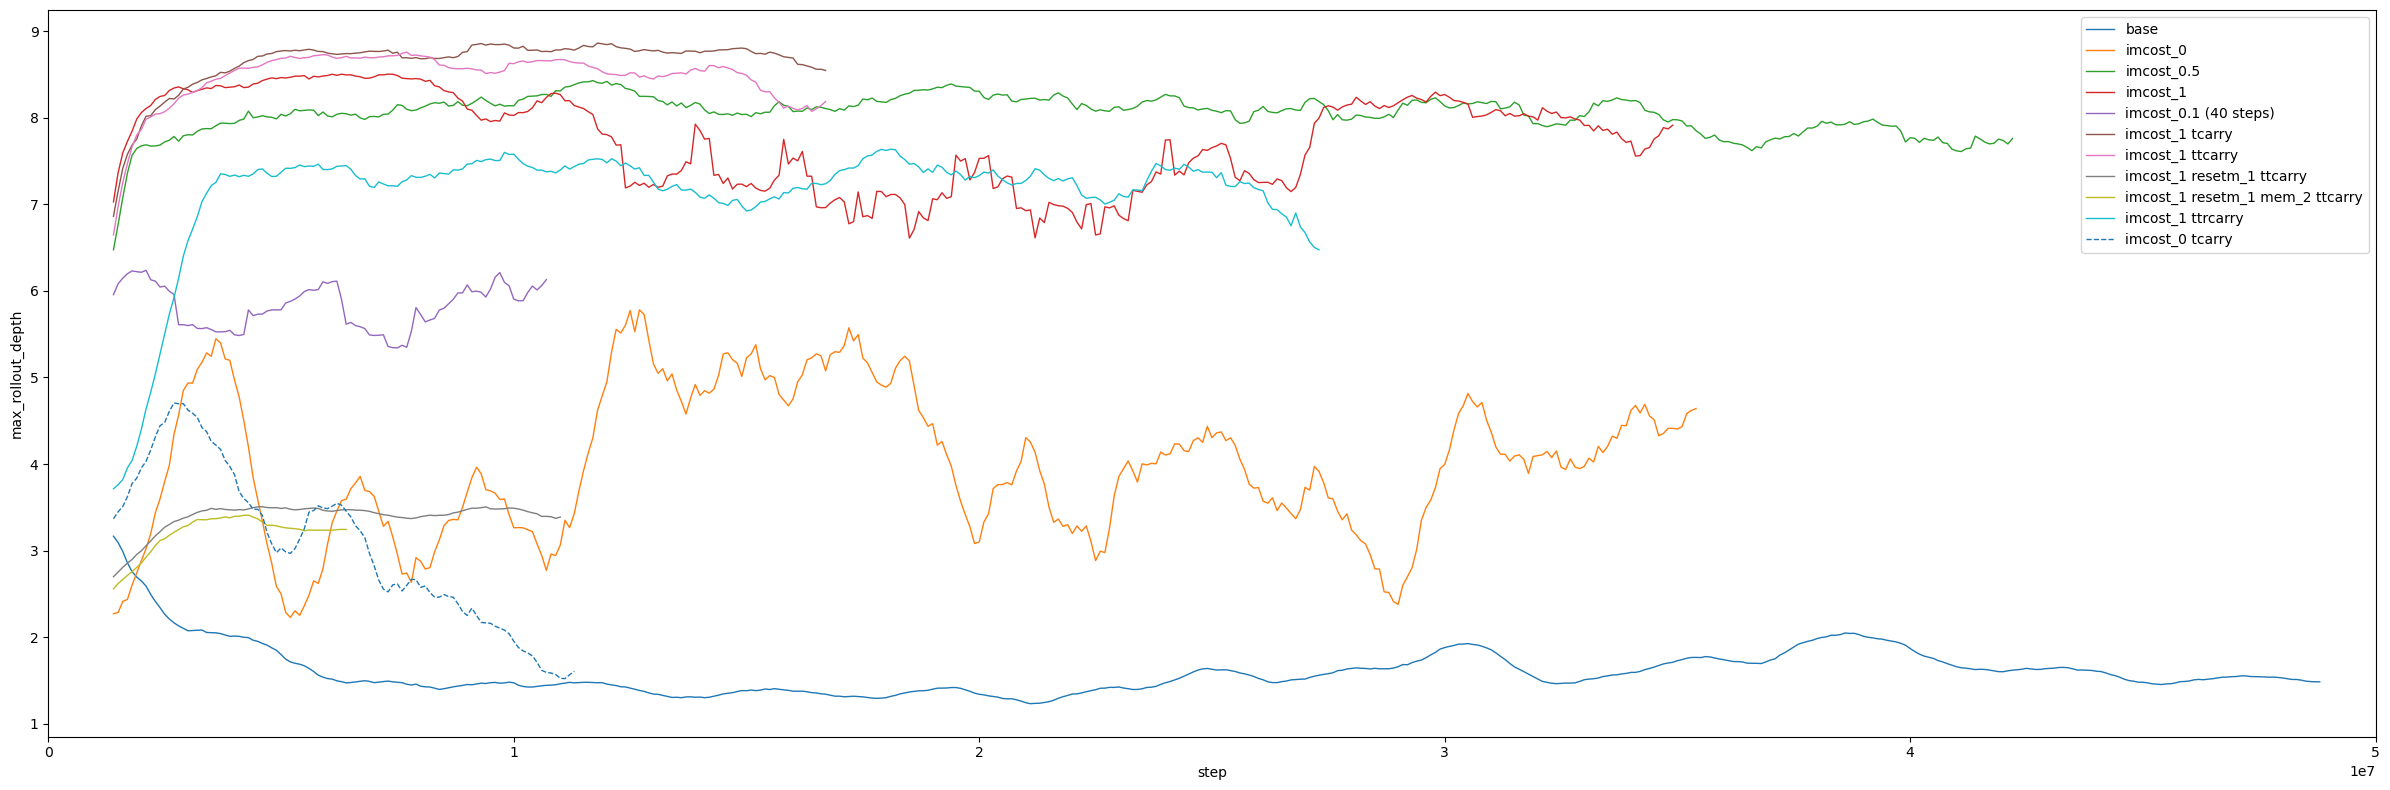

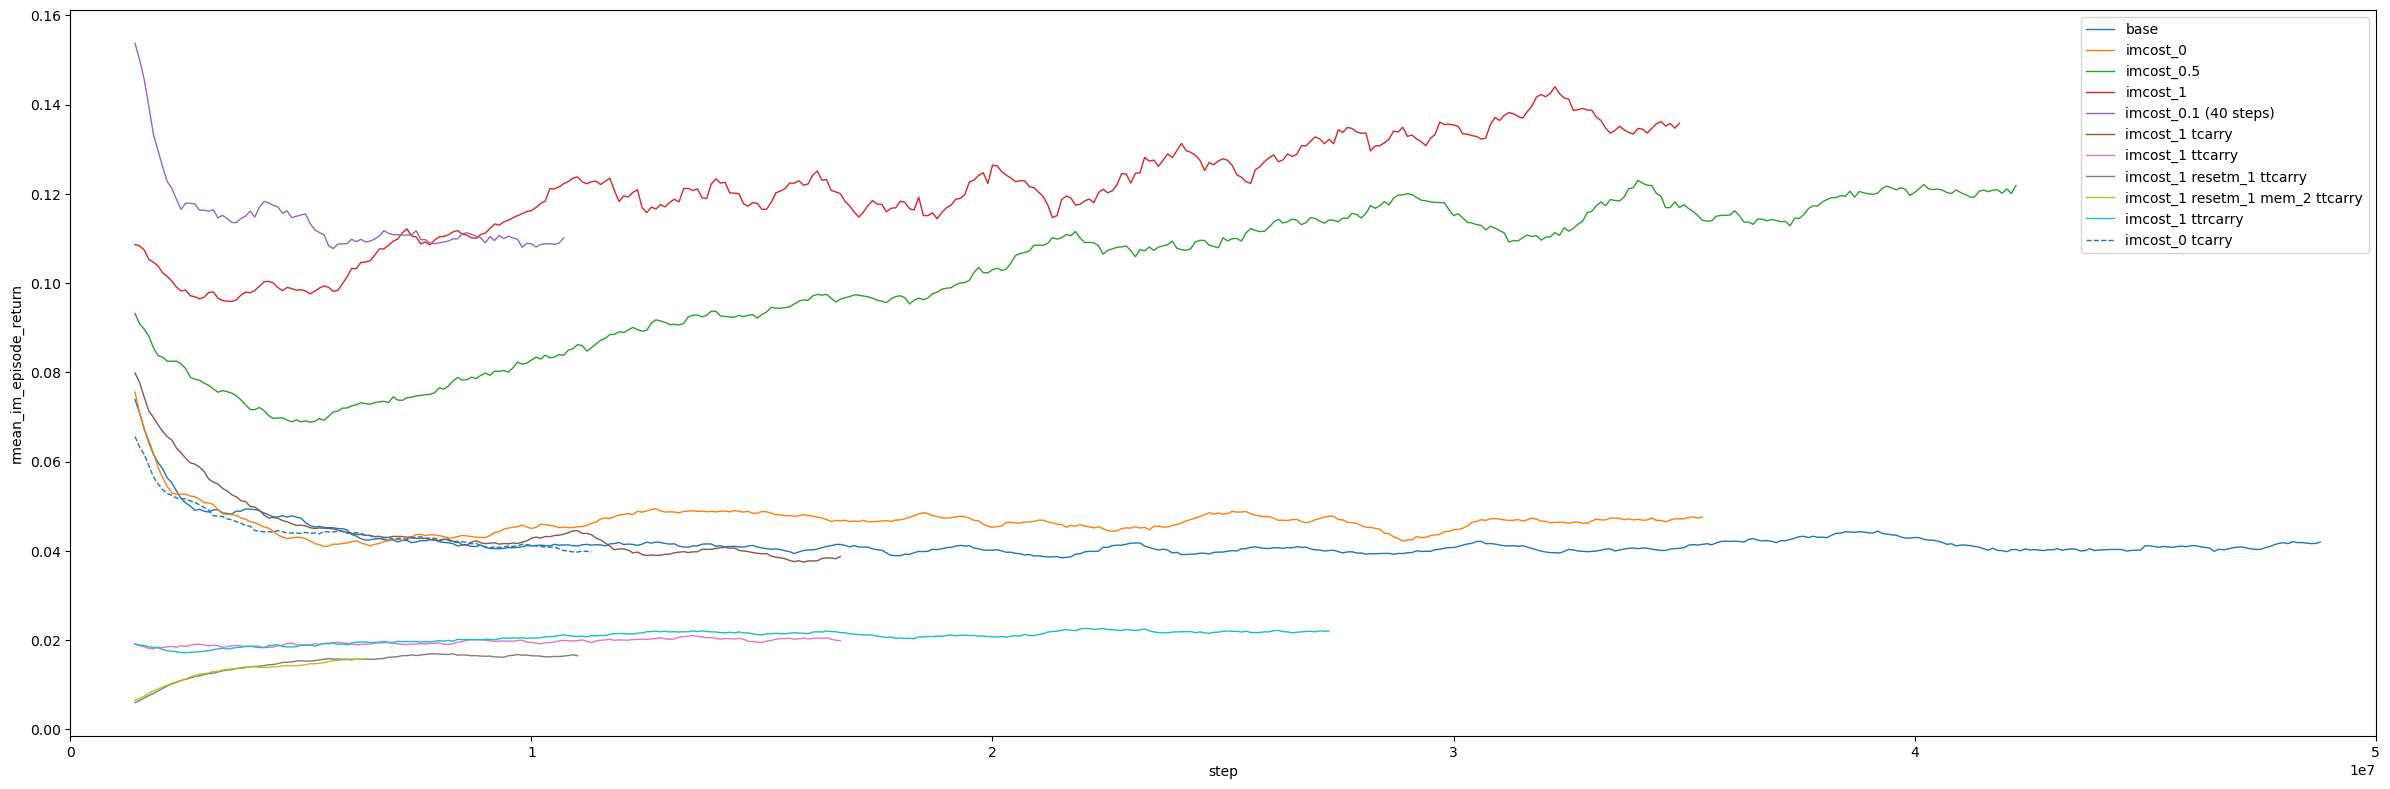

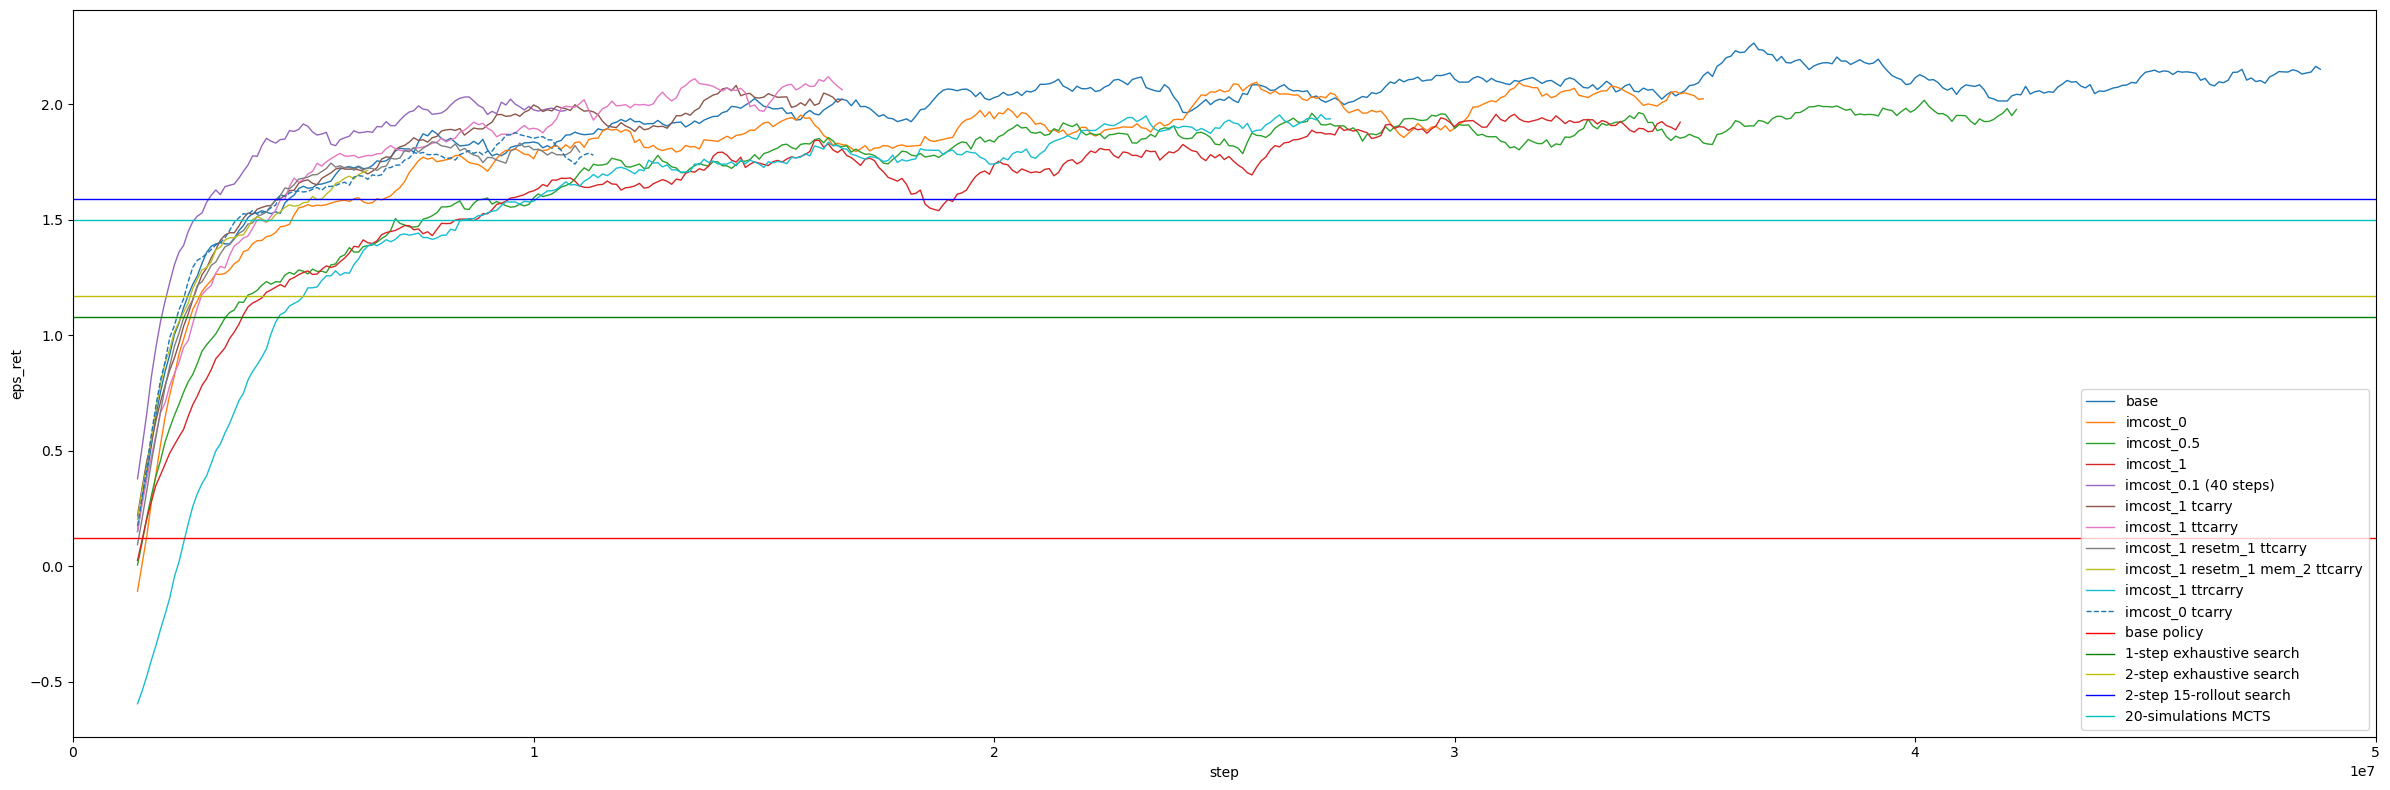

In [15]:
all_stats = download()
plot_dict = {
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem0_imcost_0_perfect": "base",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect": "imcost_0",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect": "imcost_0.5",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect": "imcost_1",   
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.25_perfect_largeclip": "imcost_0.25, largeclip",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect_resetm_1_largeclip": "imcost_0.5, largeclip, resetm_1",
   #"alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect_resetm_1_nograd": "imcost_0.5, nograd, resetm_1, nograd",
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0_perfect": "imcost_0 (20 steps)",   
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0.25_perfect": "imcost_0.25 (20 steps)",
   #"alstm_3_1_rec_n_20_rei_aug2_clip_mem1_imcost_0.5_perfect": "imcost_0.5 (20 steps)",    
   "alstm_3_1_rec_n_40_rei_aug2_clip_mem1_imcost_0.1_perfect": "imcost_0.1 (40 steps)", 
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry": "imcost_1 tcarry",    
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry": "imcost_1 ttcarry",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_resetm_1": "imcost_1 resetm_1 ttcarry",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem2_imcost_1_perfect_treecarry_threscarry_resetm_1": "imcost_1 resetm_1 mem_2 ttcarry",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect_treecarry_threscarry_rewardcarry": "imcost_1 ttrcarry",    
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect_treecarry": "imcost_0 tcarry",
}

plot(all_stats, "max_rollout_depth", plot_dict, mv_avg=15, xlim=int(5e7))
plot(all_stats, "rmean_im_episode_return", plot_dict, mv_avg=15, xlim=int(5e7))
plot(all_stats, "eps_ret", plot_dict, mv_avg=15, xlim=int(5e7))

In [ ]:
plot_dict = {"lstm_3_1_rec_n_5_w": "Backprop",
             "lstm_3_1_rec_n_5_gbste": "GB-STE",
             "lstm_3_1_rec_n_5_ste": "STE",
              "lstm_3_1_rec_n_5_rei": "REINFORCE",        
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "GB-STE",
             "lstm_3_1_rec_n_5_gbste_aug": "GB-STE w/ augmented stat.",
             "lstm_3_1_rec_n_5_rei": "REINFORCE",        
             "lstm_3_1_rec_n_5_rei_aug": "REINFORCE w/ augmented stat.",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "LSTM",
             "tran_3_1_rec_n_5_gbste_aug": "Transformer",        
             "alstm_3_1_rec_n_5_gbste_aug": "LSTM w/ attn. (4 steps)",
             "alstm_3_1_rec_n_10_gbste_aug": "LSTM w/ attn. (9 steps)",          
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"lstm_3_1_rec_n_5_gbste": "LSTM_3_1",
             "tran_3_1_rec_n_5_gbste_aug": "Transformer",        
             "alstm_3_1_rec_n_5_gbste_aug": "ALSTM_3_1 (4 steps)",
             "alstm_3_1_rec_n_10_gbste_aug": "ALSTM_3_1 (9 steps)",             
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps; clipped)",             
             "alstm_3_1_rec_n_2_gbste_aug_clip": "ALSTM_3_1 (1 steps; clipped)",                     
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps)",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps)",    
             "alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; no mem.)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "ALSTM_3_1 (4 steps; no mem.)",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "ALSTM_3_1 (9 steps; no mem.)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {
             "alstm_3_1_rec_n_1_gbste_aug_clip": "ALSTM_3_1 (0 steps; clipped)",
             "alstm_3_1_rec_n_5_gbste_aug_clip": "ALSTM_3_1 (4 steps; clipped)",             
             "alstm_3_1_rec_n_10_gbste_aug_clip": "ALSTM_3_1 (9 steps; clipped)",
             "alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "ALSTM_3_1 (4 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "ALSTM_3_1 (9 steps; clipped; real_no_mem)",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {#"alstm_3_1_rec_n_1_rei_aug_clip_realnomem": "ALSTM_3_1 (0 steps; clipped; real_no_mem)",
             "alstm_3_1_rec_n_5_rei_aug_clip_realnomem": "4 steps; REINFORCE",
             "alstm_3_1_rec_n_10_rei_aug_clip_realnomem": "9 steps; REINFORCE", 
             #"alstm_3_1_rec_n_1_gbste_aug_clip_realnomem": "ALSTM_3_1 (0 steps; no mem.)",                  
             "alstm_3_1_rec_n_5_gbste_aug_clip_realnomem": "4 steps; GB-STE",                          
             "alstm_3_1_rec_n_10_gbste_aug_clip_realnomem": "9 steps; GB-STE",
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(10e7))

plot_dict = {"alstm_3_1_rec_n_10_rei_clip_realnomem": "Stat type 1", 
             "alstm_3_1_rec_n_10_rei_aug_clip_realnomem": "Stat type 2", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem0": "Stat type 3", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "Stat type 3 (with real mem)",  
            }
plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(5e7))

plot_dict = {
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem0": "Stat type 3", 
             "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "Stat type 3 (with real mem)",  
            }
plot(all_stats, "max_rollout_depth", plot_dict, mv_avg=20, xlim=int(5e7))

plot_dict = {
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0": "im_cost=0",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5": "im_cost=0.5",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1": "im_cost=1",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0_perfect": "im_cost=0 (perfect)",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_0.5_perfect": "im_cost=0.5 (perfect)",
   "alstm_3_1_rec_n_10_rei_aug2_clip_mem1_imcost_1_perfect": "im_cost=1 (perfect)",    
   
}

plot(all_stats, "eps_ret", plot_dict, mv_avg=20, xlim=int(5e7))
plot(all_stats, "max_rollout_depth", plot_dict, mv_avg=20, xlim=int(5e7))